# Splice Continuity Analysis
Compare various metrics on either side of splice points and test null hypotheses. Have to account for seasonality. There won't be hard answers, but I want to be consistent with my assumptions between stations/cities. That's really the point of this analysis.

Steps:
1. Compile a list of candidate splices
1. Write a test suite
1. Apply to each candidate splice

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
from pathlib import Path
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

import src.data.reshape as rs
import src.analysis.continuity as cont

In [4]:
# supplement default JS plots with backup static PNGs.
# This lets them render on GitHub
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [5]:
pd.options.display.max_columns= 50

In [6]:
gsod = rs.get_gsod()

In [7]:
gsod.head(2)

,timestamp,usaf,wban,temp_f_mean,temp_count,dew_point_f_mean,dew_point_count,sea_level_pressure_mbar_mean,sea_level_pressure_count,pressure_mbar_mean,pressure_count,visbility_miles_mean,visbility_count,wind_speed_knots_mean,wind_speed_count,temp_f_max,temp_max_measurement_type,temp_f_min,temp_min_measurement_type,precipitation_total_inches,precipitation_measurement_type,snow_depth_inches,had_rain,had_snow_ice,had_hail
0,1985-01-26,691484,99999,38.099998,5,37.400002,5,NaN,0,NaN,0,4.8,5,5.2,5,39.200001,*,37.400002,*,NaN,NaN,0.8,1,0,0
1,1985-01-27,691484,99999,34.500000,5,30.600000,5,NaN,0,NaN,0,4.9,5,3.8,5,39.200001,*,30.200001,*,NaN,NaN,NaN,1,1,0


In [8]:
best_station_meta = pd.read_csv('../data/interim/stations_for_scoping_analysis.csv', dtype={'usaf': str, 'wban': str}, index_col=['usaf', 'wban'])
best_station_meta.head(2)

,,min,max,count,time_coverage,name,country,state,call,latitude,longitude,elevation_ft,nominal_begin_date,nominal_end_date,nearest_city,distance_km,nominal_duration_years
usaf,wban,,,,,,,,,,,,,,,,
723650,23050,1941-07-01,2022-04-17,28281,0.958321,ALBUQUERQUE INTL SUNPORT AIRP,US,NM,KABQ,35.042,-106.616,1618.5,1941-07-01,2021-09-21,Albuquerque,5.659381,80.224504
726770,24033,1935-05-01,2022-04-17,20143,0.634146,BILLINGS LOGAN INTERNATIONAL,US,MT,KBIL,45.807,-108.542,1091.5,1935-05-01,2021-09-21,Billings,4.148528,86.392882


In [9]:
subset_cols = ['timestamp', 'temp_f_mean', 'temp_count', 'temp_f_max', 'temp_f_min', 'precipitation_total_inches',
               'temp_max_measurement_type', 'temp_min_measurement_type', 'precipitation_measurement_type',
              ]
subset = gsod.set_index(['usaf', 'wban']).loc[best_station_meta.index, subset_cols].set_index('timestamp', append=True).sort_index()

In [10]:
subset.head(2)

temp_f_mean  temp_count  temp_f_max  temp_f_min  \
usaf   wban  timestamp                                                     
711210 99999 1944-10-10    44.000000          17   59.400002   33.400002   
             1944-10-11    49.299999          24   75.400002   33.400002   

                         precipitation_total_inches temp_max_measurement_type  \
usaf   wban  timestamp                                                          
711210 99999 1944-10-10                         0.0                         *   
             1944-10-11                         0.0                         *   

                        temp_min_measurement_type  \
usaf   wban  timestamp                              
711210 99999 1944-10-10                         *   
             1944-10-11                         *   

                        precipitation_measurement_type  
usaf   wban  timestamp                                  
711210 99999 1944-10-10                              I  
             1944-10-11                              I

In [11]:
subset.shape

(904184, 8)

In [12]:
subset['daily_temp_spread'] = subset['temp_f_max'] - subset['temp_f_min']
subset['reached_freezing'] = subset['temp_f_min'].le(32).astype(np.uint8)

In [13]:
subset.shape

(904184, 10)

In [14]:
del gsod

In [15]:
path_splice = Path(r'../data/processed/splice_pairs.csv')
assert path_splice.exists()
splice_pairs = pd.read_csv(path_splice, dtype={'usaf': str, 'wban': str})
splice_pairs.head(2)

,pair_id,usaf,wban,name
0,0,726770,24033,BILLINGS LOGAN INTERNATIONAL
1,0,999999,24033,BILLINGS MUNICIPAL ARPT


In [86]:
pairs = cont._generate_pairs_from_groups(splice_pairs)#[df for id_, df in splice_pairs.set_index(['usaf', 'wban']).groupby('pair_id')]

In [88]:
pairs[11]

,,pair_id,name
usaf,wban,,
722930,93107,10,SAN DIEGO/MIRAMAR N
722931,93107,10,MARINE CORPS AIR STATION


In [89]:
col_subset = ['temp_f_mean', 'temp_f_max', 'temp_f_min', 'daily_temp_spread',]# 'precipitation_total_inches']

In [22]:
from functools import partial

In [144]:
%%time
# very slow - 4 samples per second!
out = []
test_func = partial(cont._bootstrap_ci, n_samples=2_000, quantiles=(0.025, 0.5, 0.975))
for pair in pairs:
    airport = pair.head(1)['name'][0]
    pair_dfs = cont._subset_daily_splice_groups(subset.loc[:,col_subset], pair)
    result = cont._window_test(pair_dfs[0], pair_dfs[1], window_years=10, list_of_test_funcs=[test_func])[0]
    result[0].rename(airport, inplace=True)
    out.append(result)

CPU times: user 9min 39s, sys: 14.4 s, total: 9min 54s
Wall time: 9min 36s


In [145]:
# bootstrapped confidence intervals of the difference stat(period_2) - stat(period_1)
# So a positive value means an increase over the splice point.
test_df = pd.concat([item[0] for item in out], axis=1).T
test_df

temp_f_mean                                \
                                     mean                           std   
                                    0.025     0.500     0.975     0.025   
BILLINGS LOGAN INTERNATIONAL    -0.631899  0.879177  2.311804 -0.120026   
BOISE AIR TERMINAL/GOWEN FD A   -1.363931 -0.464264  0.620073 -0.749313   
MAHLON SWEET FIELD AIRPORT      -1.308181 -0.453587  0.484212 -0.829697   
MCCARRAN INTERNATIONAL AIRPOR    0.308397  1.127136  1.952177  0.089218   
LOS ANGELES INTERNATIONAL AIR   -0.271230  0.408827  1.144293 -0.429754   
BURBANK-GLENDALE-PASA ARPT       0.386457  1.542326  2.733249 -0.428127   
PHOENIX SKY HARBOR INTL AP       1.581310  2.721218  3.917996 -0.779540   
PORTLAND TROUTDALE              -1.900420 -0.904100  0.266777 -0.570309   
TRUCKEE-TAHOE AIRPORT           -2.808086 -1.582287 -0.296769 -0.968352   
SAN DIEGO LINDBERGH FIELD        0.839643  1.863825  2.752652 -0.005600   
SAN DIEGO MIRAMAR NAS           -0.475190  0.324249  1.082818 -0.247629   
SAN DIEGO/MIRAMAR N             -0.526262  0.628387  1.950192 -0.902803   
OAKLAND METROPOLITAN            -0.187589  0.451084  1.075372 -0.054338   
SAN FRANCISCO INTL AP           -0.261230  0.297377  0.783768 -0.331132   
NAVAL AIR STATION                0.134491  0.791014  1.379879 -0.553317   
ALAMEDA(USN)                    -2.713116 -1.876192 -0.920518 -0.794119   
SNOHOMISH CO                    -1.655589 -0.568859  0.540728 -0.803666   
TUCSON INTERNATIONAL AIRPORT    -0.128154  0.772682  1.613573 -0.115187   

                                                  temp_f_max            \
                                                        mean             
                                  0.500     0.975      0.025     0.500   
BILLINGS LOGAN INTERNATIONAL   0.935392  1.863837   1.548859  3.355757   
BOISE AIR TERMINAL/GOWEN FD A  0.073110  1.109429   0.602602  1.490616   
MAHLON SWEET FIELD AIRPORT    -0.070618  0.646478   1.052118  1.927338   
MCCARRAN INTERNATIONAL AIRPOR  0.581056  1.058478   1.827274  2.901077   
LOS ANGELES INTERNATIONAL AIR  0.068291  0.608826   1.604012  2.398178   
BURBANK-GLENDALE-PASA ARPT     0.320899  1.055280   0.476741  1.733658   
PHOENIX SKY HARBOR INTL AP     0.019203  0.854098   2.205310  2.998920   
PORTLAND TROUTDALE             0.403690  1.154998  -1.646391 -0.447754   
TRUCKEE-TAHOE AIRPORT         -0.148249  0.749333  -1.797779 -0.264307   
SAN DIEGO LINDBERGH FIELD      0.693039  1.247487   1.830550  3.110165   
SAN DIEGO MIRAMAR NAS          0.279890  0.759873   0.649086  1.871555   
SAN DIEGO/MIRAMAR N            0.126228  0.997364  -0.201902  1.226498   
OAKLAND METROPOLITAN           0.309082  0.664593   1.340301  2.208721   
SAN FRANCISCO INTL AP          0.078635  0.454031   1.459908  2.203978   
NAVAL AIR STATION             -0.117823  0.275706   0.025332  0.882347   
ALAMEDA(USN)                   0.198647  0.948290  -5.572326 -4.767382   
SNOHOMISH CO                  -0.128496  0.463813  -1.315363 -0.244030   
TUCSON INTERNATIONAL AIRPORT   0.330917  0.759820   1.288575  2.137581   

                                                                       \
                                              std                       
                                  0.975     0.025     0.500     0.975   
BILLINGS LOGAN INTERNATIONAL   5.287107  0.051141  1.334145  2.522961   
BOISE AIR TERMINAL/GOWEN FD A  2.439399 -0.733463 -0.028268  0.700325   
MAHLON SWEET FIELD AIRPORT     2.924391 -0.909911 -0.083936  0.746369   
MCCARRAN INTERNATIONAL AIRPOR  3.924996  0.186599  0.826389  1.437391   
LOS ANGELES INTERNATIONAL AIR  3.190840 -0.282882  0.222185  0.696941   
BURBANK-GLENDALE-PASA ARPT     3.000833 -0.476660  0.281111  1.045836   
PHOENIX SKY HARBOR INTL AP     3.950108 -0.582197  0.004420  0.625865   
PORTLAND TROUTDALE             0.965349 -0.240647  1.117393  2.049270   
TRUCKEE-TAHOE AIRPORT          1.461909 -0.648465  0.585355  2.117050   
SAN DIEGO LINDBERGH FIE

In [146]:
plot_source = test_df.stack(level=[0,1]).reset_index().rename(columns={'level_0': 'name', 'level_1': 'measure', 'level_2': 'statistic', 0.025: 'ci_2_5', 0.5: 'median', 0.975: 'ci_97_5'})
plot_source

,name,measure,statistic,ci_2_5,median,ci_97_5
0,BILLINGS LOGAN INTERNATIONAL,daily_temp_spread,mean,4.878424,6.036079,7.168512
1,BILLINGS LOGAN INTERNATIONAL,daily_temp_spread,std,0.020648,0.688894,1.429357
2,BILLINGS LOGAN INTERNATIONAL,temp_f_max,mean,1.548859,3.355757,5.287107
3,BILLINGS LOGAN INTERNATIONAL,temp_f_max,std,0.051141,1.334145,2.522961
4,BILLINGS LOGAN INTERNATIONAL,temp_f_mean,mean,-0.631899,0.879177,2.311804
...,...,...,...,...,...,...
139,TUCSON INTERNATIONAL AIRPORT,temp_f_max,std,-0.341000,0.198404,0.704136
140,TUCSON INTERNATIONAL AIRPORT,temp_f_mean,mean,-0.128154,0.772682,1.613573
141,TUCSON INTERNATIONAL AIRPORT,temp_f_mean,std,-0.115187,0.330917,0.759820
142,TUCSON INTERNATIONAL AIRPORT,temp_f_min,mean,-3.172733,-2.140041,-1.163806


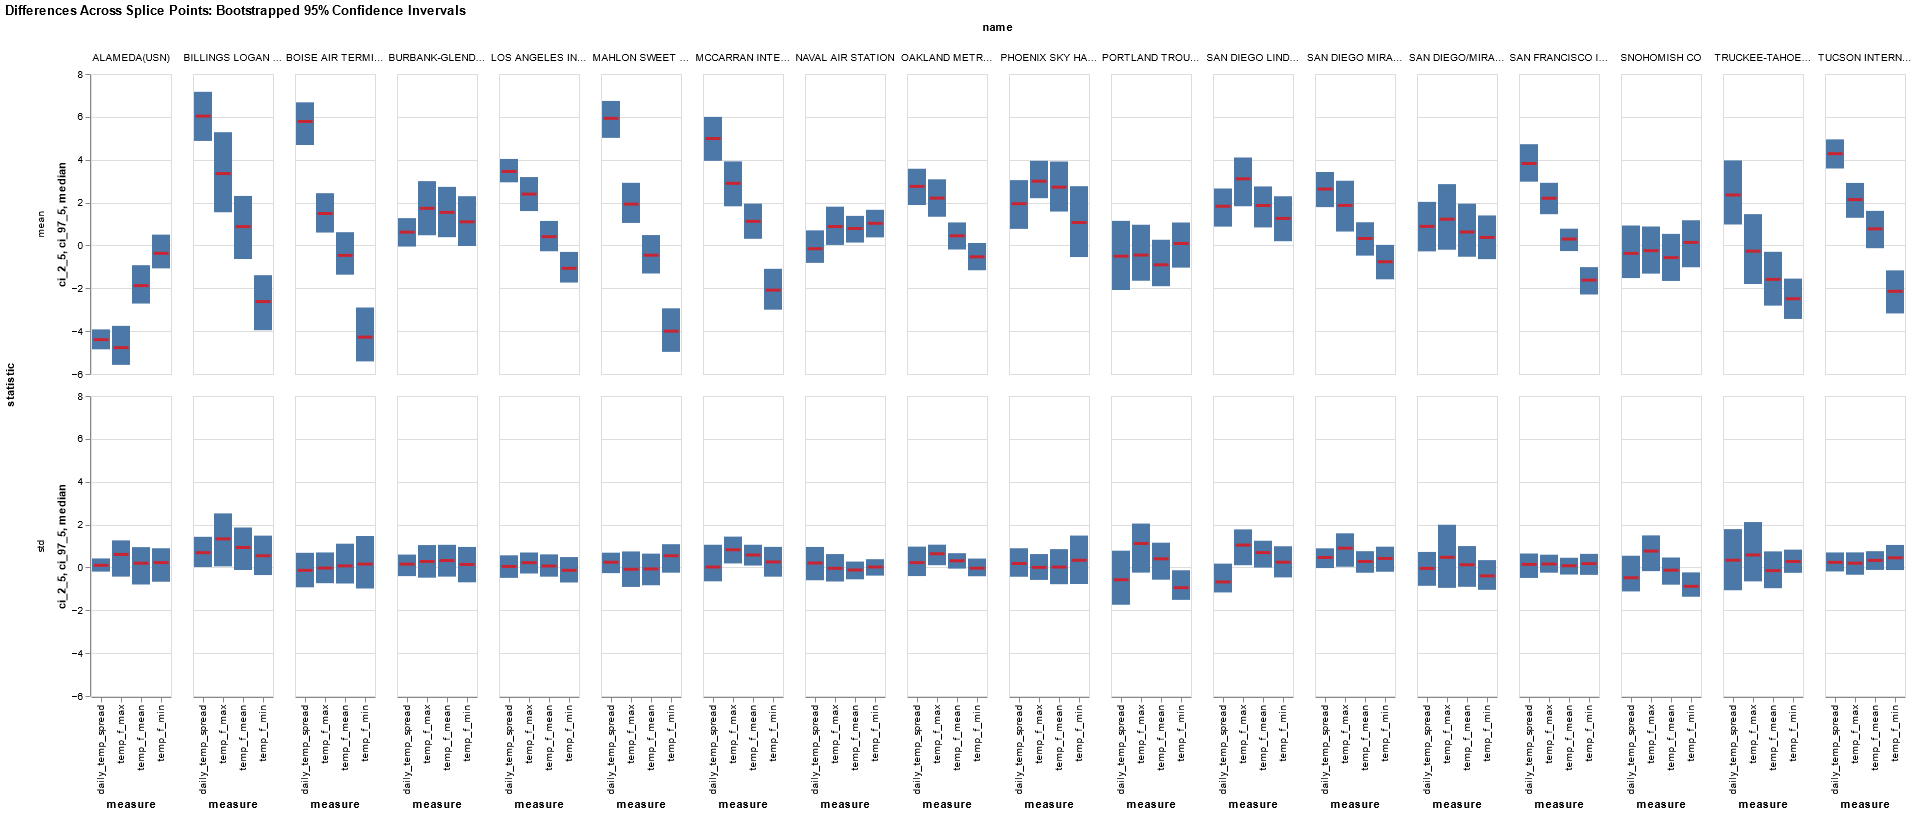

In [156]:
sort_order = plot_source.query('measure == "temp_f_mean" and statistic == "mean"').sort_values('median')['name'].to_list()
ci = alt.Chart(plot_source).mark_bar().encode(
    alt.Y('ci_2_5:Q'),
    alt.Y2('ci_97_5:Q'),
    alt.X('measure:N'),
)

median = alt.Chart(plot_source).mark_tick(color='red', thickness=3).encode(
    alt.Y('median:Q'),
    alt.X('measure:N'),
)

(ci + median).facet(
    column='name:N',
    row='statistic:N',
).properties(
    title="Differences Across Splice Points: Bootstrapped 95% Confidence Invervals"
).configure_header(
    labelLimit=100,
)

daily_temp_spread  mean    AxesSubplot(0.125,0.125;0.775x0.755)
                   std     AxesSubplot(0.125,0.125;0.775x0.755)
temp_f_max         mean    AxesSubplot(0.125,0.125;0.775x0.755)
                   std     AxesSubplot(0.125,0.125;0.775x0.755)
temp_f_mean        mean    AxesSubplot(0.125,0.125;0.775x0.755)
                   std     AxesSubplot(0.125,0.125;0.775x0.755)
temp_f_min         mean    AxesSubplot(0.125,0.125;0.775x0.755)
                   std     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

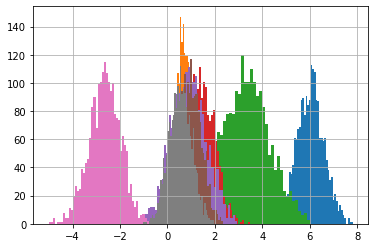

In [148]:
# raw distributions of differences for the first airport: Billings Logan Intl
out[0][1].stack(level=[0,1]).groupby(level=[1,2]).hist(bins=50)